**Important!** Do not interrupt the scripts or the opening of the savefile. If they are interrupted while data is saving or being read, the file can become corrupted.

In [1]:
#Imports
import numpy as np
import sympy as sym
import h5py as h5
from matplotlib import pyplot as plt
from scipy.integrate import quad
from scipy.integrate import dblquad
from scipy.integrate import nquad
import scipy.optimize as so
import scipy.special as ss
from scipy.special import ellipe
from scipy.special import ellipk

#Settings
options={'limit':100} #Set maximum number of subdivisions to 100 instead of 50.

In [2]:
#Constants
Mbh = 2.7e9                                                 #mass of the central black hole in (solar mass)
G = 4.300e-6                                                #gravitational constant (kpc/solar mass*(km/s)^2)
h = 8.9                                                     #radial scale-length (kpc)
rho00 = 0.31e9                                              #prefactor that will cancel
epsdisk = 5.0                                               #from Noordermeer's paper
absmag = -22.02                                             #absolute magnitude 
magsun = 4.42                                               #absolute magnitude of the sun
z0 = 0.2*h                                                  #half-thickness (kpc)
R = 4*h                                                     #cut-off radius (kpc)
d = 0.2*h                                                   #cut-off length upper limits (kpc)
L0 = np.power(10, (0.4*(magsun-absmag)))                    #Absolute Magnitude to luminosity
n = 2.7                                                     #concentration parameter that describes the curvature of the profile in a radius-magnitude plot, n=4 is de Vaucoileurs profile
re = 2.6                                                    #1kpc
ups = 2.8                                                   #mass-to-light ratio (from Rotation Curves of Sersic Bulges paper)
q = 0.33                                                    #intrinsic axis ratio
i = 45*(np.pi/180)                                          #inclination angle
L = 3.27e10                                                 #luminosity
rc = 1.4                                                    #core radius (kpc)

In [3]:
#Variables
xd = np.linspace(1, 10, 100)                        #x from/to and line smoothness
r0 = np.linspace(0.1, 10, 100)                       #radius over which plotting will be done

In [4]:
#Set up savedata

startval = str(r0[0])
endval = str(r0[len(r0)-1])
r0id = "varray_"+startval.replace('.','_')+"-"+endval.replace('.','_')+"_"+str(len(r0))+".hdf5"
location = "Inputs/"+r0id

saved = h5.File(location)

In [5]:
#Run necessary code using existing imports and variables

%run -i Scripts/bulge.py                    #Time: Roughly 2 minutes if building, Almost 0 if not.
%run -i Scripts/disk.py                     #Time: 40 Minutes if building, Almost 0 if not.
%run -i Scripts/halo.py                     #Time: Almost 0
%run -i Scripts/blackhole.py                #Time: Almost 0

saved.close()
#Total if not building is <1s

========================= Running Scripts/bulge.py ==========================

Loaded group 'bulge'.
Loaded savedata.

Finished running script for bulge velocity.
:)
========================= Running Scripts/disk.py ==========================

Loaded group 'disk'.
Loaded savedata.

Finished running script for disk velocity.
:)
========================= Running Scripts/halo.py ==========================

Loaded group 'halo'.
Loaded savedata.

Finished running script for disk velocity.
:)
========================= Running Scripts/blackhole.py ==========================

Loaded group 'blackhole'
Loaded savedata.

Finished running script for disk velocity.
:)


In [6]:
#Define total
vtotal = lambda r: np.sqrt(vcdm(r)**2+vd(r)**2+vbh(r)**2+vb(r)**2)

vtotalr = np.zeros(len(r0))
i = 0
while i < len((r0)):
    vtotalr[i] = np.sqrt(vcdmr[i]**2+vdr[i]**2+vbhr[i]**2+vbr[i]**2)
    i += 1

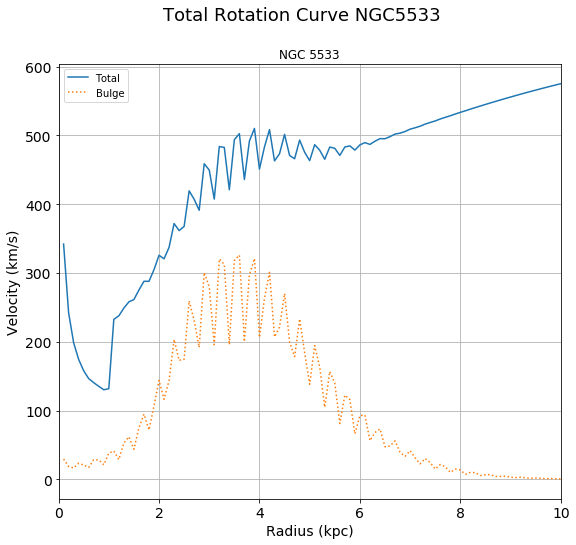

In [7]:
#Plot

fig = plt.figure(figsize=(9.0,8.0))                #size of the plot
ax = plt.axes()
ax.grid(True)
ax.yaxis.grid(True,which='minor',linestyle='--')

plt.plot(r0, vtotalr, linestyle='solid', label='Total')
#plt.plot(r0, vdr, linestyle='--', label='Disk')
#plt.plot(r0, vcdmr, linestyle='-.', label='Halo')                 #Matches Jiminez from Halo_Velocity.ipynb
plt.plot(r0, vbr, linestyle=':', label='Bulge')                   #Doesn't match Bulge_Rotation_Curve_n2_7.ipynb
#plt.plot(r0, vbhr, label='Black Hole')                            #Matches BlackHole_Velocity.ipynb

fig.suptitle('Total Rotation Curve NGC5533', fontsize=18)
ax.set(title='NGC 5533')              #labeling axes
ax.set_xlim(0,10)
ax.set_xlabel('Radius (kpc)', fontsize=14)
ax.set_ylabel('Velocity (km/s)', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14);

plt.legend()
#plt.axis([0,10,0,250])
plt.savefig('Outputs/total.png')

In [7]:
saved["disk"]

<HDF5 group "/disk" (0 members)>